In [1]:
import cv2 

img = cv2.imread(r'C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado\mariquitas\crop_89008.jpeg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

75 75 3 3


# Convolutional Neural Networks

# Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.optimizers import SGD
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [4]:
dirname = os.path.join(os.getcwd(), r'C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado')
imgpath = dirname + os.sep

images = []
directories = []
dircount = []

print("leyendo imagenes de", imgpath)

for root, _, filenames in os.walk(imgpath):
    count = 0
    for filename in filenames:
        if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename, re.IGNORECASE):
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if len(image.shape) == 3:
                images.append(image)
            count += 1
            print(f"Leyendo... {len(images)}", end="\r")

    if count > 0:  # Only add directories that have images
        directories.append(root)
        dircount.append(count)
        print(root, count)

print('Directorios leidos:', len(directories))
print("Imagenes en cada directorio", dircount)
print('Suma Total de imagenes en subdirs:', sum(dircount))

leyendo imagenes de C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado\
C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado\gatos 12500
C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado\hormigas 12386
C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado\mariquitas 10560
C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado\perros 12500
C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\dataset_recortado\tortugas 13270
Directorios leidos: 5
Imagenes en cada directorio [12500, 12386, 10560, 12500, 13270]
Suma Total de imagenes en subdirs: 61216


# Creamos las etiquetas

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  61216


In [6]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 gatos
1 hormigas
2 mariquitas
3 perros
4 tortugas


In [7]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [8]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (48972, 75, 75, 3) (48972,)
Testing data shape :  (12244, 75, 75, 3) (12244,)


Text(0.5, 1.0, 'Ground Truth : 4')

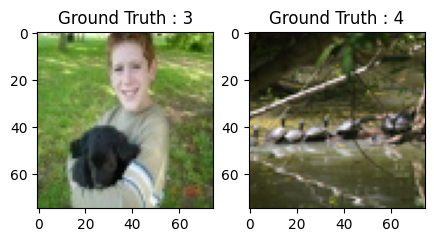

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

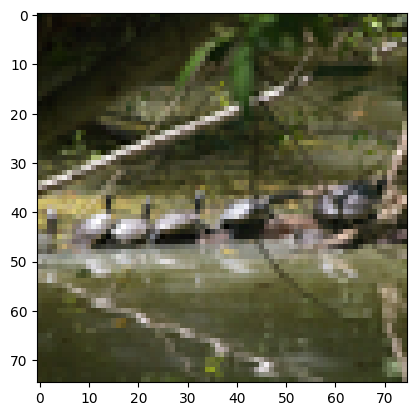

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [11]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0.]


# Creamos el Set de Entrenamiento y Validación

In [12]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [13]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(39177, 75, 75, 3) (9795, 75, 75, 3) (39177, 5) (9795, 5)


# Creamos el modelo de CNN

In [14]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-2 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 100 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size =  64 # cantidad de imágenes que se toman a la vez en memoria

In [ ]:
sport_model = Sequential()
sport_model.add(Input(shape=(75,75,3)))
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same'))
sport_model.add(LeakyReLU(negative_slope=0.1))
sport_model.add(BatchNormalization())
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.25))

sport_model.add(Conv2D(64, kernel_size=(3, 3), activation='linear', padding='same'))
sport_model.add(LeakyReLU(negative_slope=0.1))
sport_model.add(BatchNormalization())
sport_model.add(MaxPooling2D(pool_size=(2, 2)))
sport_model.add(Dropout(0.25))

# Bloque 3
sport_model.add(Conv2D(128, kernel_size=(3, 3), activation='linear', padding='same'))
sport_model.add(LeakyReLU(negative_slope=0.1))
sport_model.add(BatchNormalization())
sport_model.add(MaxPooling2D(pool_size=(2, 2)))
sport_model.add(Dropout(0.4))

sport_model.add(Flatten())
sport_model.add(Dense(64, activation='linear'))
sport_model.add(LeakyReLU(negative_slope=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

C:\Users\rival\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\rival\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
sport_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 75, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 38, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 38, 38, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         663,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             3

 Total params: 758,085 (2.89 MB)

 Trainable params: 757,637 (2.89 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
sport_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy']
)

C:\Users\rival\AppData\Roaming\Python\Python313\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Entrenamos el modelo: Aprende a clasificar imágenes

In [18]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 88s 142ms/step - accuracy: 0.5302 - loss: 1.1999 - val_accuracy: 0.4163 - val_loss: 2.4444
Epoch 2/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 88s 144ms/step - accuracy: 0.6420 - loss: 0.9063 - val_accuracy: 0.3152 - val_loss: 8.5393
Epoch 3/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 88s 143ms/step - accuracy: 0.6714 - loss: 0.8258 - val_accuracy: 0.5279 - val_loss: 1.8040
Epoch 4/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 88s 144ms/step - accuracy: 0.6955 - loss: 0.7733 - val_accuracy: 0.5233 - val_loss: 1.7501
Epoch 5/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 88s 143ms/step - accuracy: 0.7078 - loss: 0.7360 - val_accuracy: 0.4223 - val_loss: 2.5795
Epoch 6/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - accuracy: 0.7225 - loss: 0.7057 - val_accuracy: 0.4032 - val_loss: 3.2959
Epoch 7/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - accuracy: 0.7295 - loss: 0.6877 - val_accuracy: 0.4507 - val_loss: 3.9406
Epoch 8/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - accuracy: 0.7421 -

In [19]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sport.h5")

# Evaluamos la red

In [20]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7533 - loss: 0.9465


In [21]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9465008974075317
Test accuracy: 0.7532669305801392


In [22]:
sport_train.history

{'accuracy': [0.5301835536956787,
  0.6419582962989807,
  0.6713632941246033,
  0.6954845786094666,
  0.7077621817588806,
  0.7225157618522644,
  0.7294841408729553,
  0.7420680522918701,
  0.747683584690094,
  0.7576383948326111,
  0.759833574295044,
  0.7670316696166992,
  0.7739234566688538,
  0.7747147679328918,
  0.7835975289344788,
  0.7892130613327026,
  0.7884473204612732,
  0.7919442653656006,
  0.7996528744697571,
  0.8004696369171143,
  0.805549144744873,
  0.8075401186943054,
  0.8131046295166016,
  0.8167802691459656,
  0.8170865774154663,
  0.8218597769737244,
  0.8203538060188293,
  0.8250249028205872,
  0.8227786421775818,
  0.8291088938713074,
  0.832554817199707,
  0.8325293064117432,
  0.8345457911491394,
  0.8370472192764282,
  0.8379151225090027,
  0.8436582684516907,
  0.8420246839523315,
  0.8449090123176575,
  0.8454705476760864,
  0.8480741381645203,
  0.8482783436775208,
  0.8518518805503845,
  0.8534854650497437,
  0.8551190495491028,
  0.8553998470306396,
  

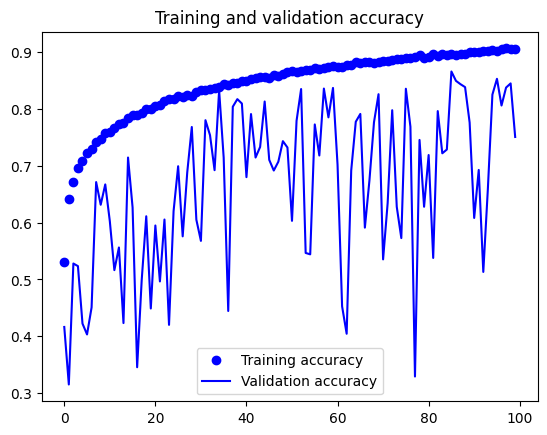

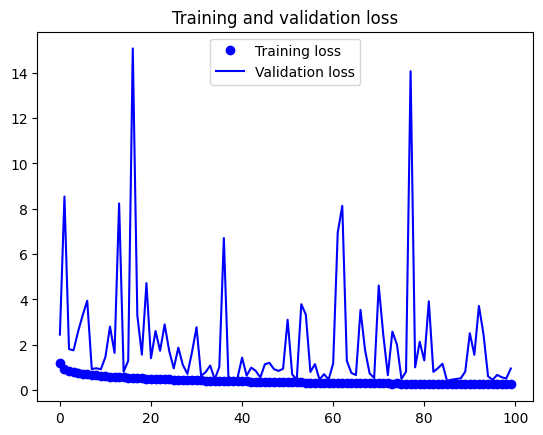

In [23]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
predicted_classes2 = sport_model.predict(test_X)

383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [25]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [26]:
predicted_classes.shape, test_Y.shape

((12244,), (12244,))

# Aprendamos de los errores: Qué mejorar

Found 9223 correct labels


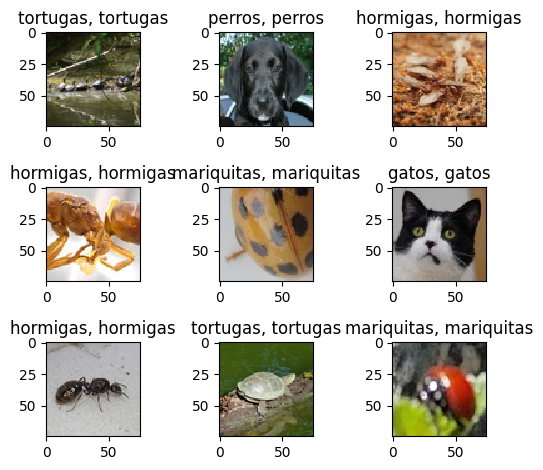

In [27]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(75,75,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 3021 incorrect labels


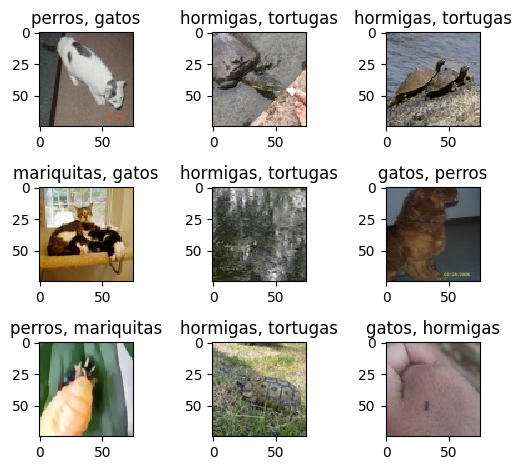

In [28]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(75,75,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [29]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.81      0.82      0.81      2489
     Class 1       0.53      0.97      0.69      2408
     Class 2       0.96      0.84      0.90      2115
     Class 3       0.86      0.72      0.79      2538
     Class 4       0.92      0.46      0.61      2694

    accuracy                           0.75     12244
   macro avg       0.82      0.76      0.76     12244
weighted avg       0.82      0.75      0.75     12244



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import load_model

sport_model = load_model("sport.keras")

deportes = ['Gato', 'Hormiga', 'Mariquita', 'Perro', 'Tortuga']  

# Lista de imágenes a probar
filenames = [r'C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\1.JPG']

images = []

for filepath in filenames:
    image = plt.imread(filepath)
    
    image_resized = resize(
        image, (64, 64), 
        anti_aliasing=True,
        clip=False,
        preserve_range=True
    )
    
    if len(image_resized.shape) == 2:
        image_resized = np.stack((image_resized,)*3, axis=-1)
    
    images.append(image_resized)

X = np.array(images, dtype=np.uint8)

test_X = X.astype('float32') / 255.0

print("Forma de test_X:", test_X.shape)

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    predicted_index = np.argmax(img_tagged)
    print(f"{filenames[i]} -> {deportes[predicted_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
C:\Users\rival\Documents\IA\Inteligencia-Artificial\Dataset\Ladybug\1.JPG mariquitas
